In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
months = ['October', 'November', 'December', 'January', 'February', 'March', 'April']

In [3]:
acc = list()

In [4]:
f1 = list()

In [5]:
err = list()

In [6]:
house_data = pd.read_csv("../preprocessed_data/std_test_data_1faa36208e696350ee3ca80197c773f062678051.csv")

In [7]:
house_data.head()

,index,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,HourofDay,Day,T_ctrl,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,T_out,RH_out
0,0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.173227,-1.11864,0.818161,0,3,0.565131,0.185707,1.760278
1,1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.173227,-1.11864,0.946499,0,17,0.565131,0.185707,1.760278
2,2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.173227,-1.11864,0.946499,0,0,0.565131,0.185707,1.760278
3,3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.173227,-1.11864,0.946499,0,3,0.565131,0.185707,1.760278
4,4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.173227,-1.11864,0.818161,0,17,0.565131,0.185707,1.760278


In [8]:
house_data.Month.value_counts()

12    8914
1     8695
11    8647
4     8622
5     8214
3     8188
6     5351
2     5181
10    1774
Name: Month, dtype: int64

In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# October

In [10]:
working_df = house_data[house_data.Month == 10]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1414, 34) (1414, 21) (354, 34) (354, 21)


In [11]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 1414 samples, validate on 354 samples
Epoch 1/20
1414/1414 [==============================] - 1s 782us/sample - loss: 0.9879 - accuracy: 0.9823 - val_loss: 0.0747 - val_accuracy: 0.9915
Epoch 2/20
1414/1414 [==============================] - 1s 391us/sample - loss: 0.0602 - accuracy: 0.9915 - val_loss: 0.0539 - val_accuracy: 0.9915
Epoch 3/20
1414/1414 [==============================] - 1s 389us/sample - loss: 0.0493 - accuracy: 0.9915 - val_loss: 0.0541 - val_accuracy: 0.9915
Epoch 4/20
1414/1414 [==============================] - 1s 377us/sample - loss: 0.0465 - accuracy: 0.9915 - val_loss: 0.0460 - val_accuracy: 0.9915
Epoch 5/20
1414/1414 [==============================] - 1s 379us/sample - loss: 0.0425 - accuracy: 0.9915 - val_loss: 0.0499 - val_accuracy: 0.9915
Epoch 6/20
1414/1414 [==============================] - 1s 378us/sample - loss: 0.0374 - accuracy: 0.9922 - val_loss: 0.0422 - val_accuracy: 0.9915
Epoch 7/20
1414/1414 [==============================] - 1s 377us/

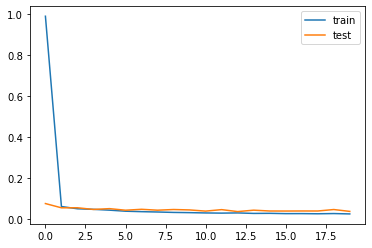

In [12]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

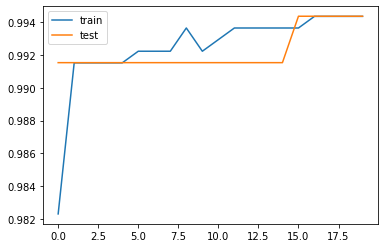

In [13]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [14]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

600
600
Error Percentage in predicted values is : 0.0 %


In [15]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9919982426672882

In [16]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [17]:
acc.append(max(history.history['accuracy']))

# November

In [18]:
working_df = house_data[house_data.Month == 11]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6912, 34) (6912, 21) (1729, 34) (1729, 21)


In [19]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6912 samples, validate on 1729 samples
Epoch 1/20
6912/6912 [==============================] - 3s 428us/sample - loss: 0.7975 - accuracy: 0.8809 - val_loss: 0.4261 - val_accuracy: 0.9225
Epoch 2/20
6912/6912 [==============================] - 3s 368us/sample - loss: 0.4326 - accuracy: 0.9230 - val_loss: 0.3839 - val_accuracy: 0.9318
Epoch 3/20
6912/6912 [==============================] - 3s 364us/sample - loss: 0.3964 - accuracy: 0.9282 - val_loss: 0.3665 - val_accuracy: 0.9329
Epoch 4/20
6912/6912 [==============================] - 3s 370us/sample - loss: 0.3799 - accuracy: 0.9310 - val_loss: 0.3434 - val_accuracy: 0.9300
Epoch 5/20
6912/6912 [==============================] - 3s 365us/sample - loss: 0.3664 - accuracy: 0.9319 - val_loss: 0.3418 - val_accuracy: 0.9341
Epoch 6/20
6912/6912 [==============================] - 3s 366us/sample - loss: 0.3582 - accuracy: 0.9323 - val_loss: 0.3616 - val_accuracy: 0.9294
Epoch 7/20
6912/6912 [==============================] - 3s 364us

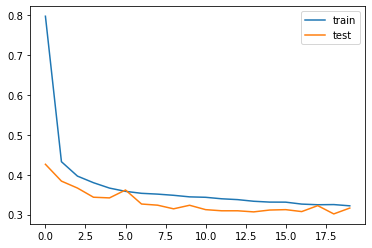

In [20]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

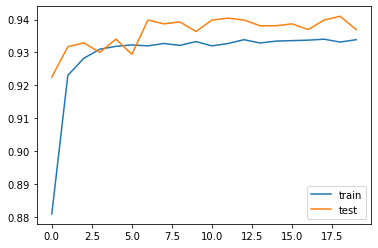

In [21]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [22]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

75450
67200
Error Percentage in predicted values is : 10.934393638170974 %


In [23]:
f1_score(y_test, y_predicted, average = 'weighted')

0.910336131423548

In [24]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [25]:
acc.append(max(history.history['accuracy']))

# December

In [26]:
working_df = house_data[house_data.Month == 12]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7126, 34) (7126, 21) (1782, 34) (1782, 21)


In [27]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 7126 samples, validate on 1782 samples
Epoch 1/20
7126/7126 [==============================] - 3s 424us/sample - loss: 0.7759 - accuracy: 0.8873 - val_loss: 0.5311 - val_accuracy: 0.9130
Epoch 2/20
7126/7126 [==============================] - 3s 367us/sample - loss: 0.4351 - accuracy: 0.9266 - val_loss: 0.4769 - val_accuracy: 0.9198
Epoch 3/20
7126/7126 [==============================] - 3s 374us/sample - loss: 0.4044 - accuracy: 0.9307 - val_loss: 0.4660 - val_accuracy: 0.9203
Epoch 4/20
7126/7126 [==============================] - 3s 375us/sample - loss: 0.3921 - accuracy: 0.9328 - val_loss: 0.4371 - val_accuracy: 0.9248
Epoch 5/20
7126/7126 [==============================] - 3s 366us/sample - loss: 0.3802 - accuracy: 0.9336 - val_loss: 0.4300 - val_accuracy: 0.9220
Epoch 6/20
7126/7126 [==============================] - 3s 367us/sample - loss: 0.3736 - accuracy: 0.9336 - val_loss: 0.4226 - val_accuracy: 0.9248
Epoch 7/20
7126/7126 [==============================] - 3s 364us

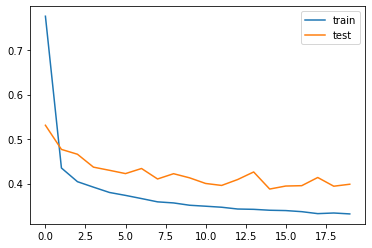

In [28]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

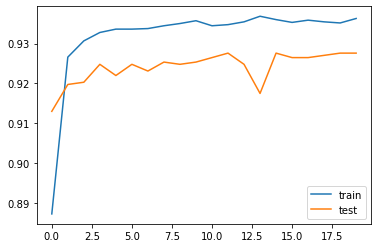

In [29]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [30]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

105675
104100
Error Percentage in predicted values is : 1.4904187366926898 %


In [31]:
f1_score(y_test, y_predicted, average = 'weighted')

0.8957561397243115

In [32]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [33]:
acc.append(max(history.history['accuracy']))

# January

In [34]:
working_df = house_data[house_data.Month == 1]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6951, 34) (6951, 21) (1738, 34) (1738, 21)


In [35]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6951 samples, validate on 1738 samples
Epoch 1/20
6951/6951 [==============================] - 3s 446us/sample - loss: 0.8734 - accuracy: 0.8468 - val_loss: 0.6313 - val_accuracy: 0.8878
Epoch 2/20
6951/6951 [==============================] - 3s 374us/sample - loss: 0.5542 - accuracy: 0.8992 - val_loss: 0.5820 - val_accuracy: 0.8976
Epoch 3/20
6951/6951 [==============================] - 3s 366us/sample - loss: 0.5187 - accuracy: 0.9049 - val_loss: 0.5555 - val_accuracy: 0.9010
Epoch 4/20
6951/6951 [==============================] - 3s 371us/sample - loss: 0.5065 - accuracy: 0.9058 - val_loss: 0.5444 - val_accuracy: 0.9005
Epoch 5/20
6951/6951 [==============================] - 3s 367us/sample - loss: 0.4953 - accuracy: 0.9074 - val_loss: 0.5308 - val_accuracy: 0.8999
Epoch 6/20
6951/6951 [==============================] - 3s 364us/sample - loss: 0.4887 - accuracy: 0.9082 - val_loss: 0.5457 - val_accuracy: 0.8982
Epoch 7/20
6951/6951 [==============================] - 3s 369us

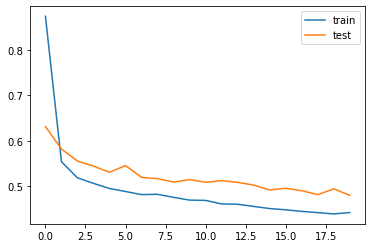

In [36]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

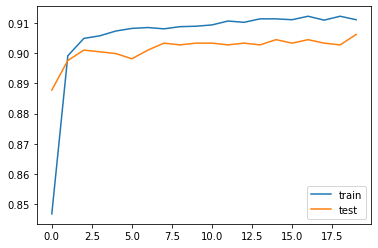

In [37]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [38]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

149595
150900
Error Percentage in predicted values is : 0.8723553594705705 %


In [39]:
f1_score(y_test, y_predicted, average = 'weighted')

0.8657335029272168

In [40]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [41]:
acc.append(max(history.history['accuracy']))

# February

In [42]:
working_df = house_data[house_data.Month == 2]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4140, 34) (4140, 21) (1035, 34) (1035, 21)


In [43]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 4140 samples, validate on 1035 samples
Epoch 1/20
4140/4140 [==============================] - 2s 412us/sample - loss: 0.9591 - accuracy: 0.8418 - val_loss: 0.5028 - val_accuracy: 0.9130
Epoch 2/20
4140/4140 [==============================] - 1s 336us/sample - loss: 0.4720 - accuracy: 0.9085 - val_loss: 0.4459 - val_accuracy: 0.9227
Epoch 3/20
4140/4140 [==============================] - 1s 323us/sample - loss: 0.4354 - accuracy: 0.9179 - val_loss: 0.4314 - val_accuracy: 0.9217
Epoch 4/20
4140/4140 [==============================] - 1s 317us/sample - loss: 0.4172 - accuracy: 0.9198 - val_loss: 0.4288 - val_accuracy: 0.9179
Epoch 5/20
4140/4140 [==============================] - 1s 323us/sample - loss: 0.4037 - accuracy: 0.9217 - val_loss: 0.4045 - val_accuracy: 0.9275
Epoch 6/20
4140/4140 [==============================] - 1s 324us/sample - loss: 0.3973 - accuracy: 0.9242 - val_loss: 0.4038 - val_accuracy: 0.9295
Epoch 7/20
4140/4140 [==============================] - 1s 316us

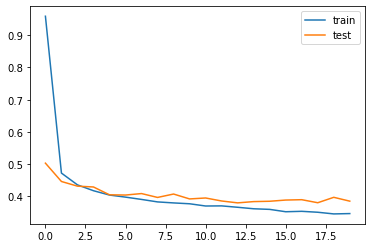

In [44]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

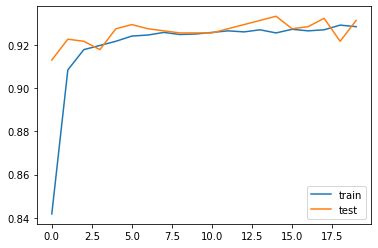

In [45]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [46]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

65070
65700
Error Percentage in predicted values is : 0.9681881051175657 %


In [47]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9038137408733771

In [48]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [49]:
acc.append(max(history.history['accuracy']))

# March

In [50]:
working_df = house_data[house_data.Month == 3]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6545, 34) (6545, 21) (1637, 34) (1637, 21)


In [51]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6545 samples, validate on 1637 samples
Epoch 1/20
6545/6545 [==============================] - 3s 430us/sample - loss: 0.7327 - accuracy: 0.8930 - val_loss: 0.4258 - val_accuracy: 0.9279
Epoch 2/20
6545/6545 [==============================] - 2s 367us/sample - loss: 0.3899 - accuracy: 0.9302 - val_loss: 0.3822 - val_accuracy: 0.9310
Epoch 3/20
6545/6545 [==============================] - 2s 365us/sample - loss: 0.3691 - accuracy: 0.9319 - val_loss: 0.3821 - val_accuracy: 0.9297
Epoch 4/20
6545/6545 [==============================] - 2s 367us/sample - loss: 0.3568 - accuracy: 0.9335 - val_loss: 0.3623 - val_accuracy: 0.9322
Epoch 5/20
6545/6545 [==============================] - 2s 377us/sample - loss: 0.3495 - accuracy: 0.9345 - val_loss: 0.3621 - val_accuracy: 0.9328
Epoch 6/20
6545/6545 [==============================] - 2s 371us/sample - loss: 0.3421 - accuracy: 0.9352 - val_loss: 0.3497 - val_accuracy: 0.9334
Epoch 7/20
6545/6545 [==============================] - 2s 370us

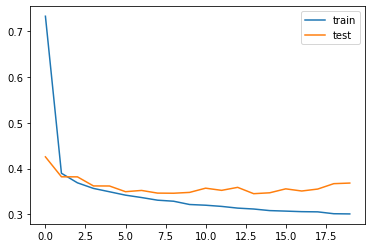

In [52]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

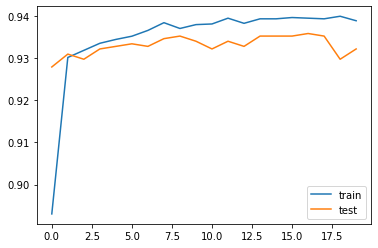

In [53]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [54]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

92760
84120
Error Percentage in predicted values is : 9.314359637774903 %


In [55]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9050345500559306

In [56]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [57]:
acc.append(max(history.history['accuracy']))

# April

In [58]:
working_df = house_data[house_data.Month == 4]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6892, 34) (6892, 21) (1724, 34) (1724, 21)


In [59]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6892 samples, validate on 1724 samples
Epoch 1/20
6892/6892 [==============================] - 3s 447us/sample - loss: 0.6781 - accuracy: 0.8897 - val_loss: 0.3385 - val_accuracy: 0.9449
Epoch 2/20
6892/6892 [==============================] - 3s 381us/sample - loss: 0.3088 - accuracy: 0.9462 - val_loss: 0.2916 - val_accuracy: 0.9524
Epoch 3/20
6892/6892 [==============================] - 3s 373us/sample - loss: 0.2807 - accuracy: 0.9497 - val_loss: 0.2673 - val_accuracy: 0.9536
Epoch 4/20
6892/6892 [==============================] - 3s 379us/sample - loss: 0.2625 - accuracy: 0.9510 - val_loss: 0.2577 - val_accuracy: 0.9542
Epoch 5/20
6892/6892 [==============================] - 3s 377us/sample - loss: 0.2545 - accuracy: 0.9527 - val_loss: 0.2510 - val_accuracy: 0.9571
Epoch 6/20
6892/6892 [==============================] - 3s 372us/sample - loss: 0.2525 - accuracy: 0.9527 - val_loss: 0.2513 - val_accuracy: 0.9582
Epoch 7/20
6892/6892 [==============================] - 3s 374us

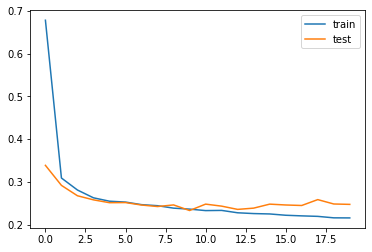

In [60]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

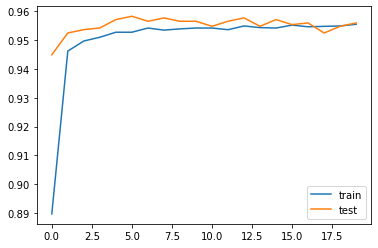

In [61]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [62]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

56010
56010
Error Percentage in predicted values is : 0.0 %


In [63]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9411652436247013

In [64]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [65]:
acc.append(max(history.history['accuracy']))

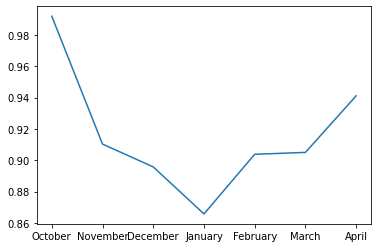

In [66]:
sns.lineplot(x = months, y = f1, sort = False)

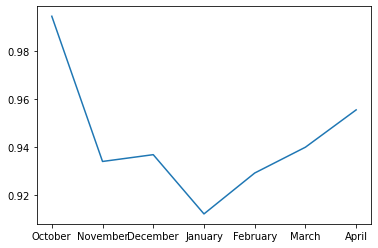

In [67]:
sns.lineplot(x = months, y = acc, sort = False)

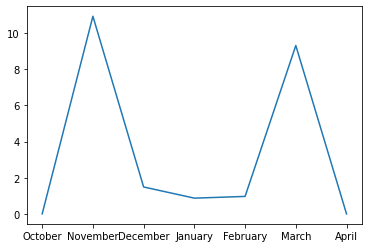

In [68]:
sns.lineplot(x = months, y = err, sort = False)